In [ ]:
# pip install -U sentence-transformers

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from IPython.display import  clear_output
import time
import PyPDF2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DEFAULT_MODEL = "meta-llama/Llama-3.2-3B-Instruct"


model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    torch_dtype=torch.bfloat16,
    use_safetensors=True,
    device_map=device,
)

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
model.generation_config.pad_token_id = 128001

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
pdf_path = 'bhagavad-gita-in-english-source-file.pdf'
pdf_reader = PyPDF2.PdfReader(pdf_path)
# Get total number of pages
num_pages = len(pdf_reader.pages)
print(f"Processing PDF with {num_pages} pages...")

full_text = []

for page_num in range(4,num_pages-1):
    page = pdf_reader.pages[page_num]
    text = page.extract_text()
    full_text.append(text)

full_text = '\n'.join(full_text)


Processing PDF with 53 pages...


In [10]:
tokenized_text = tokenizer(full_text).input_ids

In [11]:
chunk_size = 100
chunk_overlap = 20

chunk_list = []

for i in tqdm(range(0, len(tokenized_text), chunk_size - chunk_overlap)):
    print(i,i+chunk_size)
    chunk = tokenized_text[i:i+chunk_size]
    decoded_text = tokenizer.decode(chunk, skip_special_tokens=True)
    chunk_list.append(decoded_text)
    # break



 66%|██████▌   | 284/431 [00:00<00:00, 2838.60it/s]

100%|██████████| 431/431 [00:00<00:00, 2840.38it/s]

0 100
80 180
160 260
240 340
320 420
400 500
480 580
560 660
640 740
720 820
800 900
880 980
960 1060
1040 1140
1120 1220
1200 1300
1280 1380
1360 1460
1440 1540
1520 1620
1600 1700
1680 1780
1760 1860
1840 1940
1920 2020
2000 2100
2080 2180
2160 2260
2240 2340
2320 2420
2400 2500
2480 2580
2560 2660
2640 2740
2720 2820
2800 2900
2880 2980
2960 3060
3040 3140
3120 3220
3200 3300
3280 3380
3360 3460
3440 3540
3520 3620
3600 3700
3680 3780
3760 3860
3840 3940
3920 4020
4000 4100
4080 4180
4160 4260
4240 4340
4320 4420
4400 4500
4480 4580
4560 4660
4640 4740
4720 4820
4800 4900
4880 4980
4960 5060
5040 5140
5120 5220
5200 5300
5280 5380
5360 5460
5440 5540
5520 5620
5600 5700
5680 5780
5760 5860
5840 5940
5920 6020
6000 6100
6080 6180
6160 6260
6240 6340
6320 6420
6400 6500
6480 6580
6560 6660
6640 6740
6720 6820
6800 6900
6880 6980
6960 7060
7040 7140
7120 7220
7200 7300
7280 7380
7360 7460
7440 7540
7520 7620
7600 7700
7680 7780
7760 7860
7840 7940
7920 8020
8000 8100
8080 8180
8160 826

In [12]:
i=280
chunk = tokenized_text[i:i+chunk_size]
decoded_text = tokenizer.decode(chunk, skip_special_tokens=True)
print(decoded_text)

panishads and Vedanta. The prime message 
of the Gita is : The ultimate purpose of life is to realize one’s essen-
tial nature and become one with the Supreme Self within  all of us. 
It assures spiritual progress for all humans, and ho w to be one with 
the Supreme. Its teachings are profound, universal, uplifting, and 
sublime.  
The ignorance of metaphysical  or Spiritual  knowledge —not 
knowing our real identity —is


# Cleaning the text

In [13]:

def clean_text_with_llm(text):
    conversation = [
        {"role": "system", "content": f'''You are a text editor that refines extracted text while preserving its meaning. Your task is to clean up the text by:
    1. Removing any unnecessary line breaks or splits between words.
    2. Removing page numbers, footer text, and any references to links or URLs.
    3. Stripping out any other irrelevant or redundant information (e.g., citation references, headers, footers).
    4. Retaining the original content and ensuring that the flow and meaning of the text are unchanged.

    Do not add new content or make any changes that alter the overall meaning. The goal is to make the text readable, concise, and free of formatting errors typical of scanned PDFs or text extraction processes.
    Start your response immediately after the prompt do not add things like "Here is the cleaned-up text:"'''},
        {"role": "user", "content": f'''{text}'''},
    ]
    # 
    prompt = tokenizer.apply_chat_template(conversation, tokenize=False)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)


    with torch.no_grad():
        output = model.generate(**inputs,
                                do_sample=True,
                                max_new_tokens=128)


    processed_text = tokenizer.decode(output[0][len(inputs.input_ids[0])+3:], skip_special_tokens=True)

    return processed_text

In [14]:
print(decoded_text,'\n')
print(clean_text_with_llm(decoded_text).strip())

panishads and Vedanta. The prime message 
of the Gita is : The ultimate purpose of life is to realize one’s essen-
tial nature and become one with the Supreme Self within  all of us. 
It assures spiritual progress for all humans, and ho w to be one with 
the Supreme. Its teachings are profound, universal, uplifting, and 
sublime.  
The ignorance of metaphysical  or Spiritual  knowledge —not 
knowing our real identity —is 

The ultimate purpose of life is to realize one's essential nature and become one with the Supreme Self within all of us. It assures spiritual progress for all humans, and how to be one with the Supreme. Its teachings are profound, universal, uplifting, and sublime. The ignorance of metaphysical or spiritual knowledge —not knowing our real identity —is


In [15]:
cleaned_text=[]
for chunk in tqdm(chunk_list,leave=True):
    cleaned_text.append(clean_text_with_llm(chunk).strip())

100%|██████████| 431/431 [08:46<00:00,  1.22s/it]


In [2]:
import pickle

# Open a file in write-binary mode and save the list
# with open("cleaned_text.pkl", "wb") as f:
#     pickle.dump(cleaned_text, f)
    
with open("cleaned_text.pkl", "rb") as f:
    cleaned_text = pickle.load(f)

print("Loaded list:", cleaned_text)

Loaded list: ['BHAGAVAD -GITA in ENGLISH  \nAuthor: Sage Veda Vy asa  \nTranslat ed in English : Ramananda Prasad, Ph.D.  \nLanguage Editor s: Needed  \nContact: rprasad@gita -society.com  \n*****  \n“Let noble thoughts come to us from everywhere”    \n(The Vedas)  \n \nINTRODUCTION  \nThe Bhagavad -Gita is a doctrine of universal truth  and a book of moral and philosophical teachings.', 'Bhagavad -Gita is a doctrine of universal truth and a book of moral and spiritual growth. Its message is sublime and non-secular. It deals with the most sacred metaphysical science. It imparts the knowledge of the Self and answers two universal questions: Who am I, and how can I lead a happy and peaceful life in this world full of dualities and dilemmas.', 'timeless book of wisdom \nthat inspired Thoreau, Emerson, Einstein, Oppenheimer, Gandhi and many others. \nThe Bhagavad-Gita teaches us how to equip ourselves for the battle of life. A repeated study with faith purifies our psyche and guides us to 

# Creating Vector database

In [3]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

## Visualize the sentence-vecor space

/home/mohan.dash/miniconda3/envs/diffuser_data_generation/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mohan.dash/miniconda3/envs/diffuser_data_generation/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


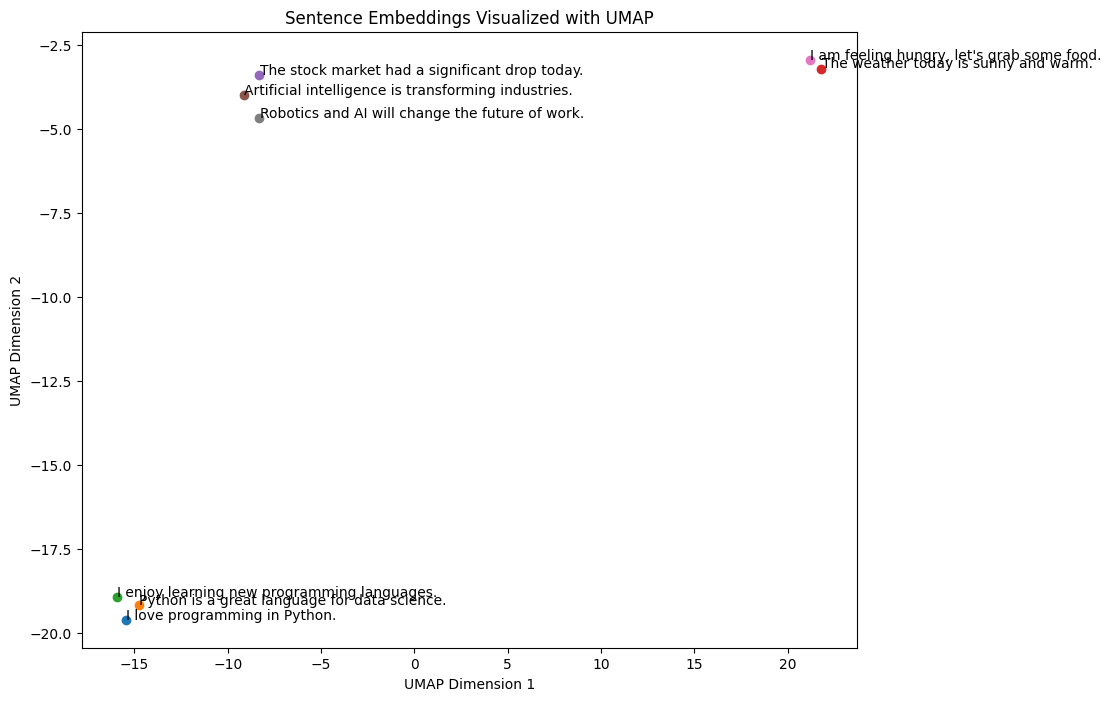

In [4]:
# 2. Example sentences
sentences = [
    "I love programming in Python.",
    "Python is a great language for data science.",
    "I enjoy learning new programming languages.",
    "The weather today is sunny and warm.",
    "The stock market had a significant drop today.",
    "Artificial intelligence is transforming industries.",
    "I am feeling hungry, let's grab some food.",
    "Robotics and AI will change the future of work."
]

# sentences = [cleaned_text[1],cleaned_text[2],cleaned_text[50],cleaned_text[51],cleaned_text[200]]

# 3. Get sentence embeddings
embeddings = embedding_model.encode(sentences)

# 4. Reduce dimensionality using UMAP
umap_model = umap.UMAP(n_neighbors=2, min_dist=0.3, metric='cosine')
umap_embeddings = umap_model.fit_transform(embeddings)

# 5. Plotting the results
plt.figure(figsize=(10, 8))

# Plot each sentence with its respective label
for i, sentence in enumerate(sentences):
    plt.scatter(umap_embeddings[i, 0], umap_embeddings[i, 1])
    plt.text(umap_embeddings[i, 0] + 0.02, umap_embeddings[i, 1] + 0.02, sentence, fontsize=10)

plt.title('Sentence Embeddings Visualized with UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [5]:
# 2. Calculate embeddings by calling model.encode()
embeddings = embedding_model.encode(cleaned_text, convert_to_tensor=True)
print(embeddings.shape)
torch.save(embeddings, "vector_embeddings.pt")

torch.Size([431, 384])


How can I stay calm and focused when facing challenges at work?
I often feel lost in life. How do I find my true purpose?
How do I deal with people who treat me unfairly?
I feel anxious about the future. How can I overcome this fear?
How can I balance my personal and professional life without stress?
I struggle to control my anger. What can I do to remain peaceful?
How do I make the right decisions when faced with difficult choices?
Why do bad things happen to good people? How should I understand suffering?
I feel demotivated and lazy. How do I develop self-discipline?
How can I practice detachment while still being responsible?

In [31]:
query = 'what kind of food one should eat?'

query_encoded = embedding_model.encode([query], convert_to_tensor=True)
similarities = embedding_model.similarity(query_encoded, embeddings)
scores, top_5_indices = torch.topk(similarities[0], k=5)
print(scores, top_5_indices)

# Step 6: Display results
print("Top 5 similar chunks:")
for idx in top_5_indices:
    print(f"Score: {similarities[0][idx]:.4f} | Chunk: {cleaned_text[idx]} \n")

tensor([0.3675, 0.3418, 0.3349, 0.3330, 0.2167], device='cuda:0') tensor([359,  72, 361, 360, 214], device='cuda:0')
Top 5 similar chunks:
Score: 0.3675 | Chunk: severe austerities without following the prescription of the scriptures, who are full of hypocrisy and egoism, who are impelled by the force of desire and attachment, and who torture the elements in their body and also I dwell within the body. 
Three types of food are also of three types. So are the sacrifice, austerity, and charity. 

Score: 0.3418 | Chunk: themselves (without
first offering to Me, or sharing with others), in truth, eat sin (3.13). 
The physical body of living beings is made up of and sustained by food; food is created by God from five basic elements. God is pleased by the sacrifice (Qurbani) of self-interest : The selfless philanthropic work, and less selfless persons. Selfless work or sacrifices 

Score: 0.3349 | Chunk: persons in the mode of goodness. 
-people in the mode of passion like foods that are ver

In [32]:
CONTEXT_TEXT = '\n'.join([cleaned_text[idx] for idx in top_5_indices if similarities[0][idx]>0])

In [33]:

conversation = [
    {"role": "system", "content": f'''You are a compassionate guide. 
     You answer questions based only on the given context of Gita and do not add any extra information.
     If the question asked by the user is not raleted to the context, you say 'this is not relate dto bhagabat gita'. 
     Your goal is to first interprete the writtings of gita in the given context and then try your best to relate to user's query.
     Answer in simple english that a 15 year old can undrestand using your interpretation of the given text. 
     CONTEXT : {CONTEXT_TEXT}. 
     Answer should not be longer than 100 words. Do not use markdown format'''},
    {"role": "user", "content": f'''{query}. '''},
]
# 
prompt = tokenizer.apply_chat_template(conversation, tokenize=False)
inputs = tokenizer(prompt, return_tensors="pt").to(device)


with torch.no_grad():
    output = model.generate(
        **inputs,
        do_sample=True,
        max_new_tokens=256
    )


processed_text = tokenizer.decode(output[0][len(inputs.input_ids[0])+3:], skip_special_tokens=True)

print(processed_text)

According to Bhagavad Gita, the three types of food are bitter, sour, salty, hot, pungent, dry, and burning, which cause pain, grief, and disease. These foods are suitable for people in the mode of passion. If you want to follow the path of goodness, you should eat food that is sweet, mild, and nourishing, as it is pleasing to the Lord. This type of food is said to be offered to the sacred fire and is considered selfless. Eat food that is simple, wholesome, and nourishing, and offer it to the Lord as an act of devotion.


In [41]:
from kokoro import KPipeline
from IPython.display import display, Audio
import soundfile as sf

tts_pipeline = KPipeline(lang_code='a') # <= make sure lang_code matches voice

/home/mohan.dash/miniconda3/envs/diffuser_data_generation/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/home/mohan.dash/miniconda3/envs/diffuser_data_generation/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [43]:
generator = tts_pipeline(processed_text,voice='af_bella')

audios = []
for i, (gs, ps, audio) in enumerate(generator):
    audios.append(audio)
    
AUDIO = torch.cat(audios, dim=0)

display(Audio(data=AUDIO, rate=24000))

# Putting it all together

In [54]:
def RAG_GITA(query):
    query_encoded = embedding_model.encode([query], convert_to_tensor=True)
    similarities = embedding_model.similarity(query_encoded, embeddings)
    scores, top_5_indices = torch.topk(similarities[0], k=5)
    print(scores, top_5_indices)

    CONTEXT_TEXT = '\n'.join([cleaned_text[idx] for idx in top_5_indices if similarities[0][idx]>0])

    conversation = [
        {"role": "system", "content": f'''You are a compassionate guide. 
        You answer questions based only on the given context of Gita and do not add any extra information. 
        Your goal is to first interprete the writtings of gita in the given context and then try your best to relate to user's query.
        Answer in simple english that a 15 year old can undrestand using your interpretation of the given text. 
        CONTEXT : {CONTEXT_TEXT}. 
        Answer should not be longer than 100 words. Do not use markdown format'''},
        {"role": "user", "content": f'''{query}. '''},
    ]
    # 
    prompt = tokenizer.apply_chat_template(conversation, tokenize=False)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)


    with torch.no_grad():
        output = model.generate(
            **inputs,
            do_sample=True,
            max_new_tokens=256
        )


    processed_text = tokenizer.decode(output[0][len(inputs.input_ids[0])+3:], skip_special_tokens=True)

    generator = tts_pipeline(processed_text,voice='af_bella')

    audios = []
    for i, (gs, ps, audio) in enumerate(generator):
        audios.append(audio)
        
    AUDIO = torch.cat(audios, dim=0)
    
    return AUDIO

query = '''what is better, islam or hinduism'''
AUDIO = RAG_GITA(query)
display(Audio(data=AUDIO, rate=24000))

tensor([0.5221, 0.4332, 0.4314, 0.4198, 0.4119], device='cuda:0') tensor([283, 112, 117, 108, 396], device='cuda:0')
